In [1]:
"""
================================================================================
YOLO MODEL TRAINING PIPELINE FOR URBAN ISSUES DETECTION
================================================================================
Autonomous City Issue Resolution Agent (GovTech)

This file is divided into sections. Copy each section into a separate 
Jupyter Notebook cell and run sequentially.

Classes:
    0: Damaged Road Issues
    1: Pothole Issues  
    2: Illegal Parking Issues
    3: Broken Road Sign Issues
    4: Fallen Trees
    5: Littering/Garbage on Public Places
    6: Vandalism Issues
    7: Dead Animal Pollution
    8: Damaged Concrete Structures
    9: Damaged Electric Wires and Poles
================================================================================
"""


"""
================================================================================
SECTION 1: IMPORTS AND SETUP
================================================================================
"""
import os
import shutil
import yaml
import random
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import seaborn as sns
from ultralytics import YOLO
import torch

BASE_DIR = Path(r"D:\B.Tech\ProjeX\18 City Issue")
DATASET_DIR = BASE_DIR / "Dataset"
MODEL_DIR = BASE_DIR / "Model"
MERGED_DIR = BASE_DIR / "Dataset_Merged"
IMG_SIZE = 640

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    DEVICE = 0
else:
    print("\n[!] GPU NOT DETECTED - Training will use CPU (SLOW)")
    print("    To install PyTorch 2.9.0 with CUDA 13.0 (Windows/Linux):")
    print("    pip uninstall torch torchvision torchaudio -y")
    print("    pip cache purge")
    print("    pip install torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0 --index-url https://download.pytorch.org/whl/cu130")
    print("    (For CPU-only or other CUDA builds like cu126/cu128, see https://pytorch.org/get-started/locally/)")
    DEVICE = "cpu"

print(f"\nBase directory: {BASE_DIR}")
print(f"Device: {DEVICE}")



PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.0 GB

Base directory: D:\B.Tech\ProjeX\18 City Issue
Device: 0


In [2]:
"""
================================================================================
SECTION 2: DATASET CONFIGURATION
================================================================================
"""
CLASS_NAMES = {
    0: "Damaged Road Issues",
    1: "Pothole Issues",
    2: "Illegal Parking Issues",
    3: "Broken Road Sign Issues",
    4: "Fallen Trees",
    5: "Littering/Garbage on Public Places",
    6: "Vandalism Issues",
    7: "Dead Animal Pollution",
    8: "Damaged Concrete Structures",
    9: "Damaged Electric Wires and Poles"
}

DATASET_MAPPING = {
    "Potholes and RoadCracks/Potholes and RoadCracks": {
        "class_map": {1: 1},
        "name": "Potholes"
    },
    "Garbage/Garbage": {
        "class_map": {5: 5},
        "name": "Garbage"
    },
    "FallenTrees/FallenTrees": {
        "class_map": {4: 4},
        "name": "FallenTrees"
    },
    "DamagedElectricalPoles/DamagedElectricalPoles": {
        "class_map": {9: 9},
        "name": "DamagedElectricalPoles"
    },
    "Damaged concrete structures/Damaged concrete structures": {
        "class_map": {8: 8},
        "name": "DamagedConcrete"
    },
    "DamagedRoadSigns/DamagedRoadSigns": {
        "class_map": {0: 3, 1: 3},
        "name": "DamagedRoadSigns"
    },
    "DeadAnimalsPollution/DeadAnimalsPollution": {
        "class_map": {7: 7},
        "name": "DeadAnimals"
    },
    "Graffitti/Graffitti": {
        "class_map": {6: 6},
        "name": "Graffiti"
    },
    "IllegalParking/IllegalParking": {
        "class_map": {0: 2, 1: 2, 2: 2},
        "name": "IllegalParking"
    }
}

print(f"Total classes: {len(CLASS_NAMES)}")
for idx, name in CLASS_NAMES.items():
    print(f"  {idx}: {name}")


Total classes: 10
  0: Damaged Road Issues
  1: Pothole Issues
  2: Illegal Parking Issues
  3: Broken Road Sign Issues
  4: Fallen Trees
  5: Littering/Garbage on Public Places
  6: Vandalism Issues
  7: Dead Animal Pollution
  8: Damaged Concrete Structures
  9: Damaged Electric Wires and Poles


In [3]:
"""
================================================================================
SECTION 3: CREATE MERGED DATASET DIRECTORY STRUCTURE
================================================================================
"""
def create_merged_dataset_structure():
    for split in ["train", "valid", "test"]:
        (MERGED_DIR / "images" / split).mkdir(parents=True, exist_ok=True)
        (MERGED_DIR / "labels" / split).mkdir(parents=True, exist_ok=True)
    print(f"Created merged dataset structure at: {MERGED_DIR}")

create_merged_dataset_structure()

Created merged dataset structure at: D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged


In [4]:
"""
================================================================================
SECTION 4: MERGE AND RELABEL DATASETS
================================================================================
"""
def relabel_annotation(label_path, class_map, is_segmentation=False):
    if not label_path.exists():
        return None
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    new_lines = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        parts = line.split()
        if len(parts) < 5:
            continue
            
        old_class = int(parts[0])
        if old_class not in class_map:
            continue
            
        new_class = class_map[old_class]
        
        if len(parts) == 5:
            cx, cy, bw, bh = map(float, parts[1:5])
        else:
            coords = list(map(float, parts[1:]))
            xs = coords[0::2]
            ys = coords[1::2]
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            cx = (x_min + x_max) / 2.0
            cy = (y_min + y_max) / 2.0
            bw = x_max - x_min
            bh = y_max - y_min
        
        new_line = f"{new_class} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}"
        new_lines.append(new_line)
    
    return new_lines if new_lines else None

def merge_datasets():
    stats = {split: {cls: 0 for cls in CLASS_NAMES.keys()} for split in ["train", "valid", "test"]}
    
    for dataset_path, config in tqdm(DATASET_MAPPING.items(), desc="Merging datasets"):
        dataset_full_path = DATASET_DIR / dataset_path
        class_map = config["class_map"]
        dataset_name = config["name"]
        
        for split in ["train", "valid", "test"]:
            images_dir = dataset_full_path / split / "images"
            labels_dir = dataset_full_path / split / "labels"
            
            if not images_dir.exists():
                print(f"Skipping {dataset_name}/{split} - images not found")
                continue
            
            image_files = list(images_dir.glob("*.[jJ][pP][gG]")) + \
                         list(images_dir.glob("*.[jJ][pP][eE][gG]")) + \
                         list(images_dir.glob("*.[pP][nN][gG]"))
            
            for img_path in image_files:
                label_name = img_path.stem + ".txt"
                label_path = labels_dir / label_name
                
                new_lines = relabel_annotation(label_path, class_map)
                if new_lines is None:
                    continue
                
                new_img_name = f"{dataset_name}_{img_path.name}"
                new_label_name = f"{dataset_name}_{img_path.stem}.txt"
                
                dst_img = MERGED_DIR / "images" / split / new_img_name
                dst_label = MERGED_DIR / "labels" / split / new_label_name
                
                shutil.copy2(img_path, dst_img)
                
                with open(dst_label, 'w') as f:
                    f.write('\n'.join(new_lines))
                
                for line in new_lines:
                    cls = int(line.split()[0])
                    stats[split][cls] += 1
    
    return stats

def merged_dataset_exists():
    for split in ["train", "valid", "test"]:
        images_dir = MERGED_DIR / "images" / split
        labels_dir = MERGED_DIR / "labels" / split
        if not images_dir.exists() or not labels_dir.exists():
            return False
        if not list(images_dir.glob("*")) or not list(labels_dir.glob("*.txt")):
            return False
    return True

if merged_dataset_exists():
    print(f"Merged dataset already exists at: {MERGED_DIR}")
    print("Skipping dataset merge.")
    stats = None
else:
    print("Merging datasets...")
    stats = merge_datasets()
    
    print("\n Dataset Statistics:")
    for split, class_stats in stats.items():
        total = sum(class_stats.values())
        print(f"\n{split.upper()}: {total} annotations")
        for cls, count in class_stats.items():
            if count > 0:
                print(f"  {cls}: {CLASS_NAMES[cls]} - {count}")



Merged dataset already exists at: D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged
Skipping dataset merge.


In [5]:
"""
================================================================================
SECTION 5: GENERATE DATA.YAML CONFIG FILE
================================================================================
"""
data_yaml = {
    "path": str(MERGED_DIR),
    "train": "images/train",
    "val": "images/valid",
    "test": "images/test",
    "nc": len(CLASS_NAMES),
    "names": list(CLASS_NAMES.values())
}

yaml_path = MERGED_DIR / "data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"Created data.yaml at: {yaml_path}")
print("\nContents:")
with open(yaml_path, 'r') as f:
    print(f.read())



Created data.yaml at: D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged\data.yaml

Contents:
names:
- Damaged Road Issues
- Pothole Issues
- Illegal Parking Issues
- Broken Road Sign Issues
- Fallen Trees
- Littering/Garbage on Public Places
- Vandalism Issues
- Dead Animal Pollution
- Damaged Concrete Structures
- Damaged Electric Wires and Poles
nc: 10
path: D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged
test: images/test
train: images/train
val: images/valid



In [6]:
"""
================================================================================
SECTION 6: VALIDATE DATASET INTEGRITY
================================================================================
"""
def validate_dataset():
    issues = []
    
    for split in ["train", "valid", "test"]:
        images_dir = MERGED_DIR / "images" / split
        labels_dir = MERGED_DIR / "labels" / split
        
        image_files = list(images_dir.glob("*"))
        label_files = list(labels_dir.glob("*.txt"))
        
        image_stems = {f.stem for f in image_files}
        label_stems = {f.stem for f in label_files}
        
        missing_labels = image_stems - label_stems
        missing_images = label_stems - image_stems
        
        if missing_labels:
            issues.append(f"{split}: {len(missing_labels)} images missing labels")
        if missing_images:
            issues.append(f"{split}: {len(missing_images)} labels missing images")
        
        print(f"{split}: {len(image_files)} images, {len(label_files)} labels")
    
    if issues:
        print("\n Issues found:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("\n All files validated successfully!")
    
    return len(issues) == 0

validate_dataset()



train: 33557 images, 33557 labels
valid: 4032 images, 4032 labels
test: 3995 images, 3995 labels

 All files validated successfully!


True

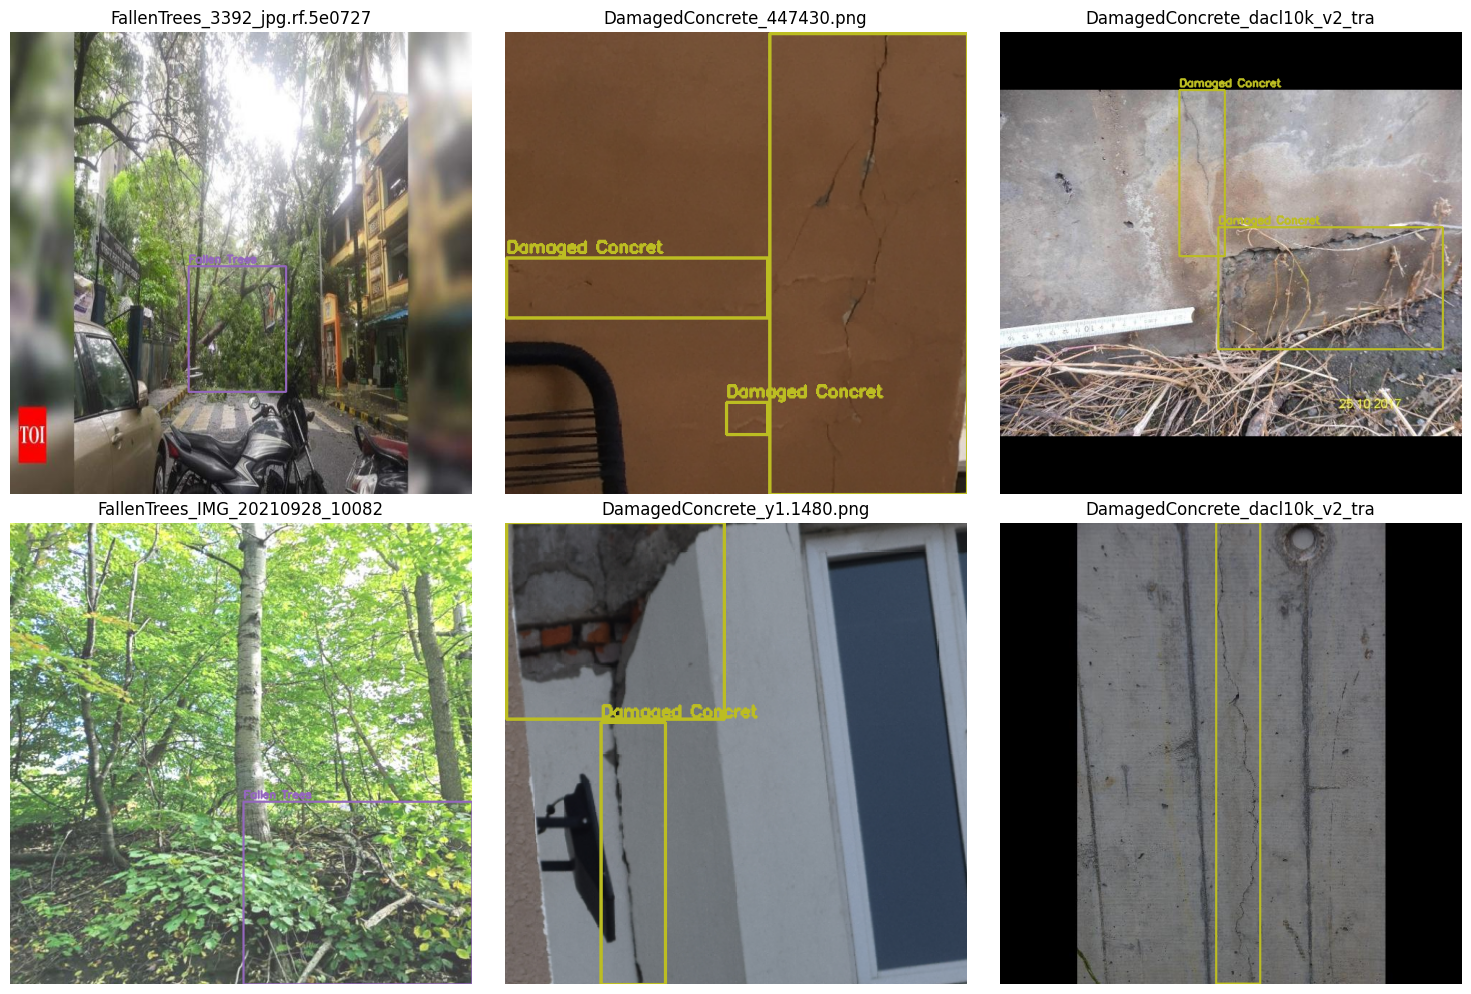

Saved sample visualization to: D:\B.Tech\ProjeX\18 City Issue\Model\sample_annotations.png


In [7]:

"""
================================================================================
SECTION 7: VISUALIZE SAMPLE IMAGES WITH ANNOTATIONS
================================================================================
"""
def visualize_samples(n_samples=6):
    train_images = list((MERGED_DIR / "images" / "train").glob("*"))
    sample_images = random.sample(train_images, min(n_samples, len(train_images)))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for idx, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        label_path = MERGED_DIR / "labels" / "train" / (img_path.stem + ".txt")
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls = int(parts[0])
                        
                        if len(parts) == 5:
                            cx, cy, bw, bh = map(float, parts[1:5])
                            x1 = int((cx - bw/2) * w)
                            y1 = int((cy - bh/2) * h)
                            x2 = int((cx + bw/2) * w)
                            y2 = int((cy + bh/2) * h)
                        else:
                            coords = list(map(float, parts[1:]))
                            xs = [coords[i] * w for i in range(0, len(coords), 2)]
                            ys = [coords[i] * h for i in range(1, len(coords), 2)]
                            x1, x2 = int(min(xs)), int(max(xs))
                            y1, y2 = int(min(ys)), int(max(ys))
                        
                        color = tuple(int(c * 255) for c in colors[cls][:3])
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(img, CLASS_NAMES[cls][:15], (x1, y1-5), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        axes[idx].imshow(img)
        axes[idx].set_title(img_path.name[:30])
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(MODEL_DIR / "sample_annotations.png", dpi=150)
    plt.show()
    print(f"Saved sample visualization to: {MODEL_DIR / 'sample_annotations.png'}")

visualize_samples()


In [8]:
"""
================================================================================
SECTION 8: TRAIN YOLO MODEL
================================================================================
"""
model = YOLO("yolov8s.pt")

results = model.train(
    data=str(MERGED_DIR / "data.yaml"),
    epochs=100,
    imgsz=IMG_SIZE,
    batch=8,
    patience=60,
    save=True,
    project=str(MODEL_DIR),
    name="urban_issues_yolov8",
    exist_ok=True,
    pretrained=True,
    optimizer="AdamW",
    lr0=0.001,
    lrf=0.01,
    momentum=0.9,
    weight_decay=0.0005,
    verbose=True,
    seed=42,
    deterministic=True,
    plots=True,
    save_period=10,
    val=True,
    device=DEVICE,
    cache=False,
    workers=6,
    cos_lr=True,
    warmup_epochs=5,
    overlap_mask=True,
    augment=True,
    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.1,
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=2.0,
    perspective=0.0005,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    fliplr=0.5,
)

print("\nTraining completed!")
print(f"Best model saved at: {MODEL_DIR / 'urban_issues_yolov8' / 'weights' / 'best.pt'}")


WARNING 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.250  Python-3.11.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=urban_issues_yolo

In [9]:
"""
================================================================================
SECTION 9: EVALUATE MODEL ON VALIDATION SET
================================================================================
"""
best_model_path = MODEL_DIR / "urban_issues_yolov8" / "weights" / "best.pt"
model = YOLO(str(best_model_path))

val_results = model.val(
    data=str(MERGED_DIR / "data.yaml"),
    split="val",
    imgsz=IMG_SIZE,
    batch=32,
    device=DEVICE,
    workers=4,
    save_json=True,
    plots=True
)

print("\nValidation Results:")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")





Ultralytics 8.3.250  Python-3.11.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 650.9234.9 MB/s, size: 171.0 KB)
val: Scanning D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged\labels\valid.cache... 4032 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4032/4032 2.6Mit/s 0.0s
val: D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged\images\valid\DamagedConcrete_dacl10k_v2_train_1079_jpg.rf.7101a4f6ff6310b343f4c7c3192e593e.jpg: 1 duplicate labels removed
val: D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged\images\valid\DamagedConcrete_dacl10k_v2_train_1415_jpg.rf.5baa774e055cd0a042a1467f1c4f3352.jpg: 3 duplicate labels removed
val: D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged\images\valid\DamagedConcrete_dacl10k_v2_train_1560_jpg.rf.5a50b63f642b058f2f2524b2807b4032.jpg: 1 duplicate labels removed
val: D:\B.Tech\ProjeX\18 City Issue\Dataset_Me

In [10]:
"""
================================================================================
SECTION 10: RUN INFERENCE ON TEST SET
================================================================================
"""
test_images_dir = MERGED_DIR / "images" / "test"
test_images = list(test_images_dir.glob("*"))[:20]

results = model.predict(
    source=test_images,
    save=True,
    save_txt=True,
    project=str(MODEL_DIR),
    name="test_predictions",
    exist_ok=True,
    conf=0.25,
    iou=0.45
)

print(f"\nTest predictions saved to: {MODEL_DIR / 'test_predictions'}")

for r in results[:3]:
    print(f"\nImage: {Path(r.path).name}")
    if r.boxes is not None:
        for box in r.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            print(f"  - {CLASS_NAMES[cls]}: {conf:.2f}")





0: 512x512 2 Damaged Concrete Structuress, 14.8ms
1: 512x512 1 Damaged Concrete Structures, 14.8ms
2: 512x512 1 Damaged Concrete Structures, 14.8ms
3: 512x512 1 Damaged Concrete Structures, 14.8ms
4: 512x512 2 Damaged Concrete Structuress, 14.8ms
5: 512x512 1 Damaged Concrete Structures, 14.8ms
6: 512x512 1 Damaged Concrete Structures, 14.8ms
7: 512x512 1 Damaged Concrete Structures, 14.8ms
8: 512x512 1 Damaged Concrete Structures, 14.8ms
9: 512x512 1 Damaged Concrete Structures, 14.8ms
10: 512x512 2 Damaged Concrete Structuress, 14.8ms
11: 512x512 1 Damaged Concrete Structures, 14.8ms
12: 512x512 1 Damaged Concrete Structures, 14.8ms
13: 512x512 1 Damaged Concrete Structures, 14.8ms
14: 512x512 1 Damaged Concrete Structures, 14.8ms
15: 512x512 1 Damaged Concrete Structures, 14.8ms
16: 512x512 1 Damaged Concrete Structures, 14.8ms
17: 512x512 1 Damaged Concrete Structures, 14.8ms
18: 512x512 1 Damaged Concrete Structures, 14.8ms
19: 512x512 2 Damaged Concrete Structuress, 14.8ms
Speed

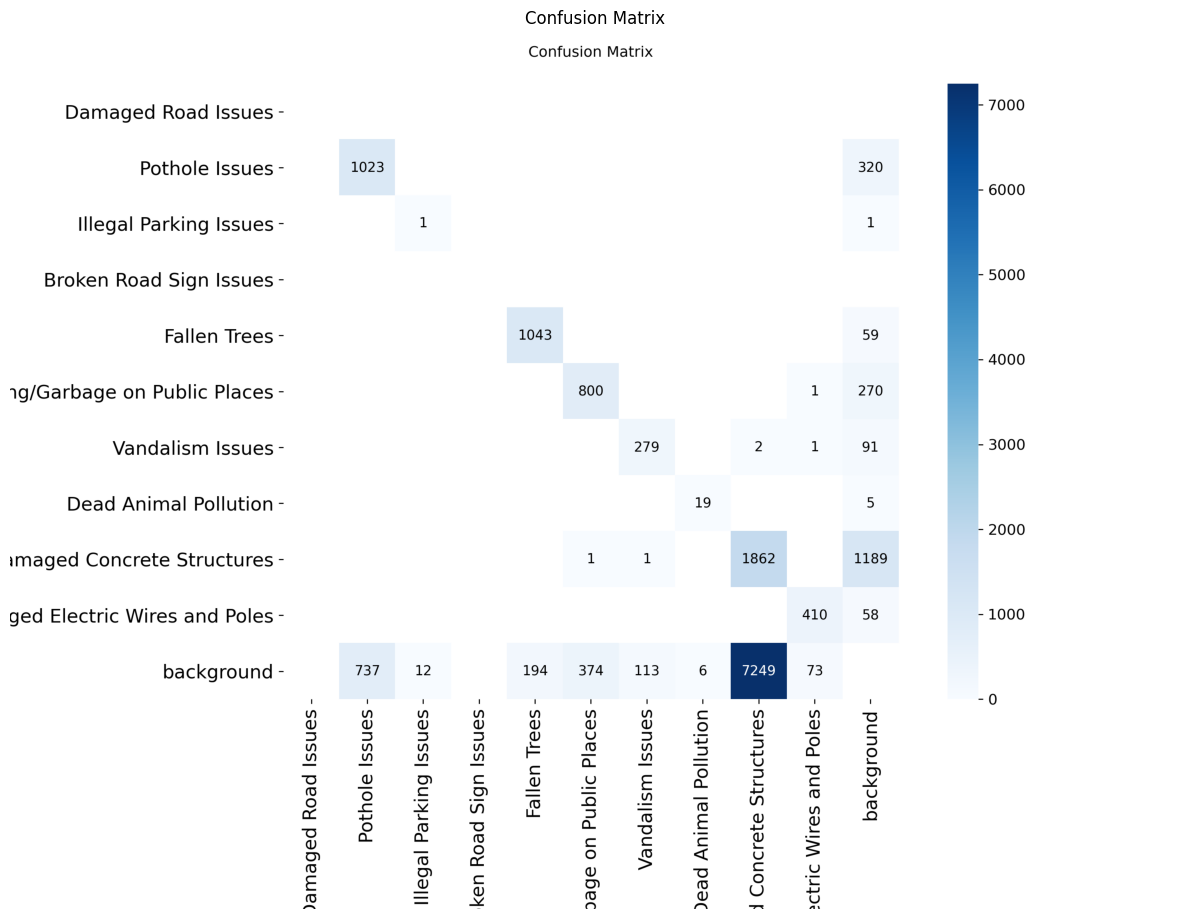

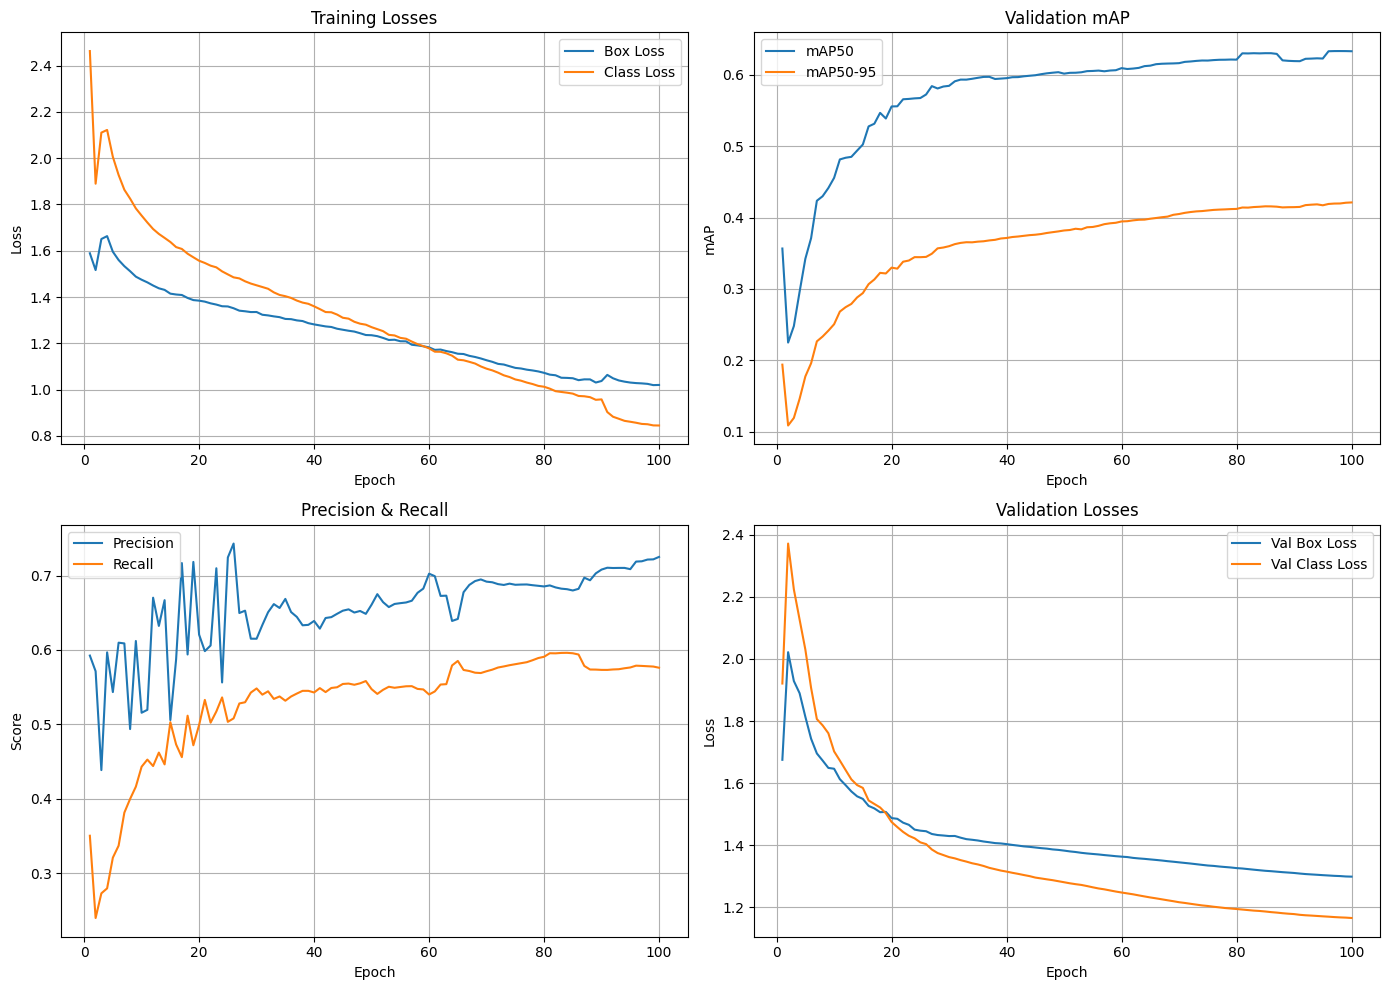

Saved training metrics to: D:\B.Tech\ProjeX\18 City Issue\Model\training_metrics.png


In [11]:
"""
================================================================================
SECTION 11: GENERATE CONFUSION MATRIX AND ANALYSIS
================================================================================
"""
confusion_matrix_path = MODEL_DIR / "urban_issues_yolov8" / "confusion_matrix.png"
if confusion_matrix_path.exists():
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix not found. Will be generated after training.")

results_csv = MODEL_DIR / "urban_issues_yolov8" / "results.csv"
if results_csv.exists():
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    if 'train/box_loss' in df.columns:
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss')
        axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training Losses')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
    
    if 'metrics/mAP50(B)' in df.columns:
        axes[0, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
        axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('mAP')
        axes[0, 1].set_title('Validation mAP')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    if 'metrics/precision(B)' in df.columns:
        axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
        axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_title('Precision & Recall')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    if 'val/box_loss' in df.columns:
        axes[1, 1].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
        axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].set_title('Validation Losses')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(MODEL_DIR / "training_metrics.png", dpi=150)
    plt.show()
    print(f"Saved training metrics to: {MODEL_DIR / 'training_metrics.png'}")




In [12]:
"""
================================================================================
SECTION 12: EXPORT OPTIMIZED MODEL
================================================================================
"""
best_model = YOLO(str(best_model_path))

onnx_path = best_model.export(format="onnx", simplify=True, dynamic=False)
print(f"Exported ONNX model to: {onnx_path}")

torchscript_path = best_model.export(format="torchscript")
print(f"Exported TorchScript model to: {torchscript_path}")

model_info = {
    "model_name": "Urban Issues YOLOv8 Detector",
    "version": "1.0",
    "classes": CLASS_NAMES,
    "input_size": IMG_SIZE,
    "best_weights": str(best_model_path),
    "onnx_path": str(onnx_path),
    "torchscript_path": str(torchscript_path),
    "val_mAP50": float(val_results.box.map50),
    "val_mAP50_95": float(val_results.box.map)
}

with open(MODEL_DIR / "model_info.yaml", 'w') as f:
    yaml.dump(model_info, f, default_flow_style=False)

print(f"\nModel info saved to: {MODEL_DIR / 'model_info.yaml'}")
print("\n" + "="*60)
print("TRAINING PIPELINE COMPLETE!")
print("="*60)
print(f"Best model: {best_model_path}")
print(f"ONNX export: {onnx_path}")
print(f"Validation mAP50: {val_results.box.map50:.4f}")
"""
================================================================================
END OF PIPELINE
================================================================================
"""


Ultralytics 8.3.250  Python-3.11.9 torch-2.9.1+cu130 CPU (AMD Ryzen 7 8845HS w/ Radeon 780M Graphics)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'D:\B.Tech\ProjeX\18 City Issue\Model\urban_issues_yolov8\weights\best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 14, 5376) (21.5 MB)

ONNX: starting export with onnx 1.20.0 opset 22...


d:\B.Tech\ProjeX\18 City Issue\.venv\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success  1.7s, saved as 'D:\B.Tech\ProjeX\18 City Issue\Model\urban_issues_yolov8\weights\best.onnx' (42.6 MB)

Export complete (2.0s)
Results saved to D:\B.Tech\ProjeX\18 City Issue\Model\urban_issues_yolov8\weights
Predict:         yolo predict task=detect model=D:\B.Tech\ProjeX\18 City Issue\Model\urban_issues_yolov8\weights\best.onnx imgsz=512  
Validate:        yolo val task=detect model=D:\B.Tech\ProjeX\18 City Issue\Model\urban_issues_yolov8\weights\best.onnx imgsz=512 data=D:\B.Tech\ProjeX\18 City Issue\Dataset_Merged\data.yaml  
Visualize:       https://netron.app
Exported ONNX model to: D:\B.Tech\ProjeX\18 City Issue\Model\urban_issues_yolov8\weights\best.onnx
Ultralytics 8.3.250  Python-3.11.9 torch-2.9.1+cu130 CPU (AMD Ryzen 7 8845HS w/ Radeon 780M Graphics)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'D:\B.Tech\ProjeX\18 City Issue\Model\urban_issues_yolov8\wei

'\n================================================================================\nEND OF PIPELINE\n================================================================================\n'